# **1. Data Cleaning**

## *Table of Contents*

1. [**Data Cleaning**](./02_Data_Cleaning.ipynb)
   1. [*Library Imports*](#Library-Imports)
   2. [*File Importation*](#File-Importation)
   3. [*Pre-Cleaned Data Inspection*](#Pre-Cleaned-Data-Inspection)
   4. [*Data Preparation / Cleaning for Model Fitting*](#Data-Preparation--Cleaning-for-Model-Fitting)
   5. [*Post-Cleaning Data Inspection*](#Post-Cleaning-Data-Inspection)
   6. [*'BuildingArea' Imputation*](#BuildingArea-Imputation)
   7. [*Post-Analysis of 'BuildingArea' Imputation*](#Post-Analysis-of-'BuildingArea'-Imputation)
   8. [*Export Data*](#Export-Data)
2. [EDA and Feature Engineering](./03_Exploratory_Data_Analysis.ipynb)
3. [Regression Modelling](./04_Regression_Modelling.ipynb)
4. [Time_Series](./05_Time_Series.ipynb)

## **Library Imports**

Before we can dive into cleaning our data, we need to ensure we have the right tools for the job.  This section imports libraries that are crucial for handling the data cleaning tasks within this notebook.

### Standard library imports

In [1]:
import sys # Provides a way of using operating system dependent functionality
import os  # For interacting with the operating system

### Third-party imports

In [2]:
import matplotlib.pyplot as plt  # For creating visualizations
import missingno as msno  # For visualizing missing data
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis
import seaborn as sns  # For high-level data visualization

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV, SelectKBest, mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score, 
                                     StratifiedKFold, KFold)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

### Local application imports

In this section, we import custom functions that I've developed to streamline our data cleaning and visualization processes. These functions are located in separate Python files for better organization:

* **`plotting_utils.py`:** 
    * Contains functions for efficient plotting of multiple variables within a dataset. This eliminates the need to plot each variable individually, saving time and simplifying visual analysis. The file includes functions tailored to different plotting types (e.g., histograms, scatterplots, boxplots) to accommodate various visualization needs.

* **`data_prep_utils.py`:**
    * Contains a function for converting categorical columns into dummy variables. This process is necessary for many machine learning algorithms that require numerical inputs. The function also concatenates these transformed columns back into the original dataset for seamless integration in later analysis.

By leveraging these custom functions, we can make our data cleaning and exploration tasks more efficient and structured.

In [3]:
# Define the absolute path of the parent directory of the script's grandparent directory
# This is useful for module importation from a different directory structure
parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(0, parent_dir)

# Local application imports
from utils import plot_utils, func_utils

## **File Importation**

With the necessary libraries in place, we can now load our raw data and begin the cleaning process:

* **File Path:** We define a variable `data_path` to reference the location of our data within the "00_Raw_Data" folder.

* **Data Import:** We leverage the `pandas.read_csv` function to import the data into a Pandas DataFrame named `melb_data`.

* **Date Parsing:** Knowing that the dataset has a "Date" column, we employ the `parse_dates` argument within `read_csv` to ensure this column is treated as containing date values.

* **Date Format Specification:** To prevent misinterpretations, we utilize the `dayfirst=True` argument to signify that the dates follow a day-month-year format within the dataset. This guarantees accurate parsing by Pandas

In [4]:
# Determine the absolute path to the directory containing the current script
script_dir = os.path.dirname(os.path.dirname(os.getcwd()))

# Construct the path to the data file
data_path = os.path.join(script_dir, '00_Raw_Data', '0_melb_data.csv')

# Load the dataset, parsing dates to ensure proper datetime format
melb_data = pd.read_csv(data_path, parse_dates=['Date'], dayfirst=True)

C:\Users\AAA\AppData\Local\Temp\ipykernel_44320\1835048994.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  melb_data = pd.read_csv(data_path, parse_dates=['Date'], dayfirst=True)


### Date Extraction

Having a date column in our dataset provides valuable information for analysis. However, dates can also behave like categorical variables, making it challenging to utilize them directly in some machine learning models. 

To address this and explore potential trends based on time, we opted to extract two new features from the existing "Date" column:

* **Month:** This new column will represent the month (as a number between 1 and 12) for each data point.
* **Year:** This new column will capture the year for each data point.

By separating the dates into month and year components, we create features that might be more meaningful in the context of our analysis. This allows us to investigate how factors like seasonality (related to month) or yearly trends might influence the target variable we're interested in.

In [5]:
# Data manipulation: extracting year and month from the date for further analysis
melb_data['Year'] = melb_data['Date'].dt.year
melb_data['Month'] = melb_data['Date'].dt.month
melb_data['Date'] = melb_data['Date'].dt.date # Simplify 'Date' to date format

### Drop Duplicates

Our data cleaning process involved removing duplicate rows from the dataset. Duplicates can sometimes occur during data collection or processing, and eliminating them ensures we're working with a clean and representative sample.

In [6]:
# Remove duplicate entries to maintain data integrity
melb_data.drop_duplicates(inplace=True)

## **Pre-Cleaned Data Inspection**

Before diving into the data cleaning process, we performed a preliminary inspection to identify potential challenges. This involved:

* **Summary Statistics:** We obtained summary statistics for the dataset using the `describe()` function. This provided insights into the distribution of numerical values, counts, and other key metrics.

* **Identifying Missing Values:** We used the `isna().sum()` function to determine the extent of missing data (often represented as NaN - Not a Number) across different columns within the dataset.

* **Visualizing Missing Data:** We employed the `msno` library to generate a visual representation of the missing data patterns within the dataset. This helps identify columns with significant missing values or any systematic patterns in how the data is missing.

**Purpose:** This initial inspection provides a roadmap for our subsequent data cleaning efforts, guiding us in addressing missing values, potential outliers, or other data quality issues that might require attention.

              Rooms         Price      Distance      Postcode      Bedroom2  \
count  13579.000000  1.357900e+04  13579.000000  13579.000000  13579.000000   
mean       2.936151  1.075709e+06     10.137897   3105.296045      2.912365   
std        0.950368  6.393278e+05      5.868924     90.677724      0.959165   
min        1.000000  8.500000e+04      0.000000   3000.000000      0.000000   
25%        2.000000  6.500000e+05      6.100000   3044.000000      2.000000   
50%        3.000000  9.030000e+05      9.200000   3084.000000      3.000000   
75%        3.000000  1.330000e+06     13.000000   3148.000000      3.000000   
max       10.000000  9.000000e+06     48.100000   3977.000000     20.000000   

           Bathroom           Car      Landsize  BuildingArea    YearBuilt  \
count  13579.000000  13517.000000  13579.000000   7126.000000  8205.000000   
mean       1.533029      1.609899    518.087562    143.593649  1964.473248   
std        0.687940      0.962142   1272.523717     83

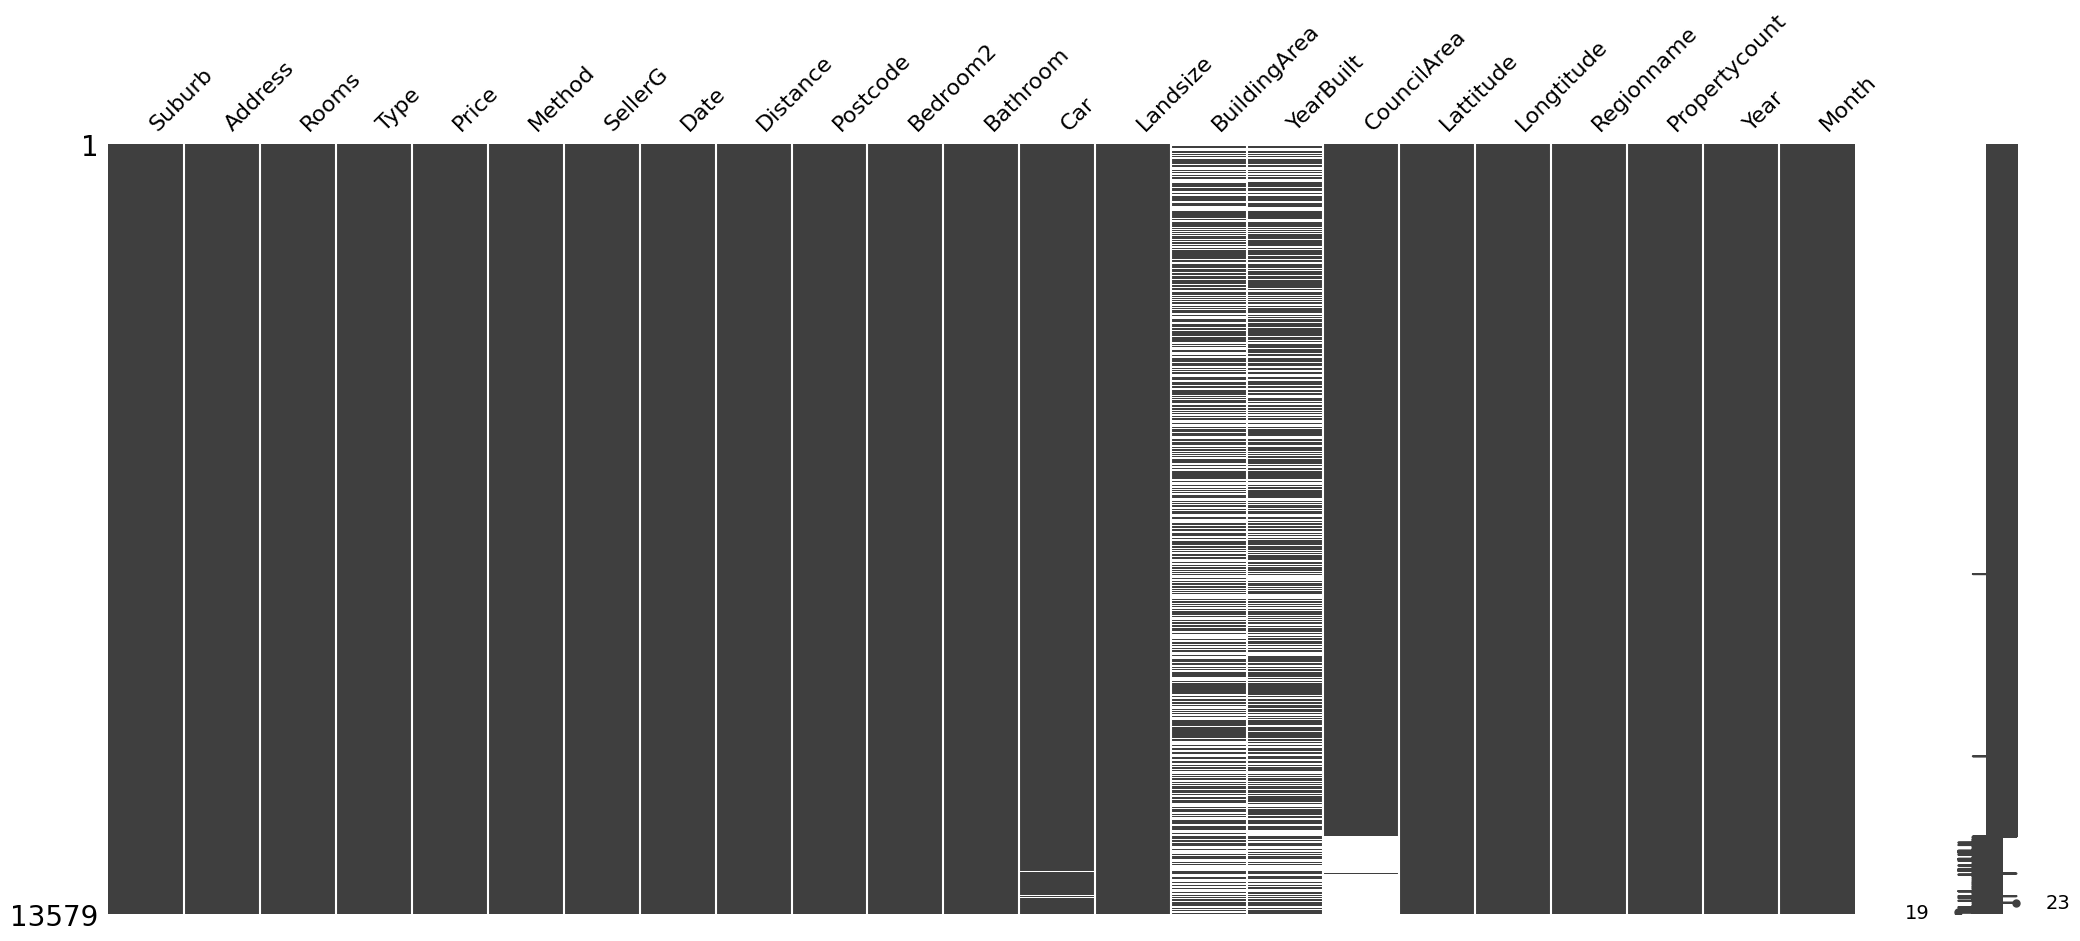

In [7]:
# Display summary statistics for the dataset
print(melb_data.describe())

# Identify missing values across columns
print('\n Missing values across columns:')
print(melb_data.isna().sum())

# Identify number of entries in dataset
print(f'\n Number of entries in dataset: {melb_data.shape[0]}')

# Visualize missing data to guide cleaning and imputation strategies
msno.matrix(melb_data)
plt.show()

Our initial inspection revealed the presence of missing values in several features:

* **Car:** A relatively small number of missing values (62 out of 13,579)
* **BuildingArea:** A significant amount of missing data (6,453)
* **YearBuilt:** A significant amount of missing data (5,374)
* **CouncilArea:** A significant amount of missing data (1,362)

**Imputation Considerations**

* **Car:** Due to the small number of missing values, imputation using mean or median might be a reasonable approach. We'll need to consider the distribution of the 'Car' feature to choose the most appropriate method.

* **BuildingArea, YearBuilt, CouncilArea:** These features have a larger proportion of missing values. Imputation with mean or median might introduce bias into our analysis. We need to explore the following options:
    * **Alternative Imputation Strategies:** Consider methods like using information from other related features to fill in the gaps.
    * **Potential Feature Dropping:** If the extent of missingness is too high and we cannot find reliable ways to impute, we might have to consider dropping these features entirely.

**Important:** Decisions on handling missing values should be made carefully, weighing the potential impact of different approaches on the integrity and representativeness of our dataset.

## **Data Preparation / Cleaning for Model Fitting**

**Removing the 'Year Built' Feature** 

Upon close inspection of the 'Year Built' feature, we identified significant inconsistencies in the recorded dates. These inconsistencies likely stem from inaccurate entries during the data collection phase. Since we cannot reliably recover the original values, we made the decision to remove this feature to prevent introducing misleading information into our analysis.

**Addressing Specific Data Issues and Other Anomalies (Beyond Missing Values)**

* **Bathrooms (Handling Inconsistencies):** We've identified an issue with the 'Bathroom' feature: some listings have an implausible value of zero bathrooms. We will need to address this issue before proceeding with our analysis.

* **Duplicate Bedroom Data ('Rooms' vs 'Bedroom2'):** We discovered a redundancy in the dataset with the presence of both a 'Rooms' and a 'Bedroom2' feature. Closer inspection reveals inconsistencies between the entries in these columns. To streamline our analysis, we'll need to address this.

### Indicator Variable Creation

Before addressing missing values and data inconsistencies, we'll create binary indicator variables for specific features. These indicators will serve several key purposes:

* **Tracking Data Changes:** These binary features will act as flags, indicating where we've modified data points within the original dataset.
    * A value of 1 will signify a data point that has been imputed (e.g., missing values in 'Car' or 'Building Area' filled in using imputation techniques).
    * A value of 0 will represent data points that remain unchanged from their original state. 

* **Improving Model Interpretation:** By including these indicators as features in our model, we provide the model with additional context. The model can then learn from both the original data values and the presence of these indicators, potentially leading to more nuanced and interpretable results.

* **Understanding the Nature of Missing Data:** Since we obtained this pre-accumulated dataset from an external source (e.g., Kaggle), we don't have detailed information about the reasons behind missing or erroneous values. There are different types of missingness, such as:
    * **Missing Completely at Random (MCAR):** There's no systematic relationship between the missingness of a value and any other observable values.
    * **Missing at Random (MAR):** The missingness of a value can be related to other observable values in the dataset. 

* **Investigating Missingness Through Modeling:** These binary indicators can be valuable during model fitting. If the indicators improve model performance, it suggests that the missingness pattern might be informative (likely MAR). If the indicators don't contribute to the model, it might point towards MCAR. This insight helps us better understand the data and make informed decisions about future data cleaning or modeling strategies.

In [8]:
# Create binary indicators for specific conditions to enhance model interpretation
melb_data['Bathroom_was_0'] = np.where(melb_data['Bathroom'] == 0, True, False)
melb_data['Car_was_missing'] = melb_data['Car'].isna()
melb_data['BuildingArea_was_missing'] = melb_data['BuildingArea'].isna()

###  Resolving Missing Values and Errors

We identified missing values in two features: 'Car' and 'Bathroom'. To address these, we employed median imputation, a technique suited for skewed distributions.

**Why Median Imputation?**

Our exploration of the data revealed that both 'Car' and 'Bathroom' exhibit right-skewed distributions. This means a larger portion of the data points lie on the lower end of the value range. In such cases, the median (the 'middle' value) is a more robust measure of central tendency compared to the mean, which can be easily influenced by extreme values on the right side of the distribution. 

In [9]:
# Replace 0 bathroom counts with the median number of bathrooms.
melb_data['Bathroom'] = np.where(melb_data['Bathroom'] == 0, melb_data['Bathroom'].median(), melb_data['Bathroom'])

# Fill missing values in 'Car' column with the median number of cars.
melb_data.fillna(value={'Car': melb_data['Car'].median()}, inplace=True)

We observed an inconsistency between the 'Rooms' and 'Bedroom2' features. To handle this conservatively, we created a function named `effective_bedrooms`. This function:

* Compares 'Rooms' and 'Bedroom2' values for each row in the dataset.
* Applies a defined logic to determine a more reliable value for the bedrooms. 
* Is applied to the entire dataset to systematically resolve the discrepancies.

**Rationale:**

By creating a specific function and applying it consistently, we ensure that the 'Rooms' vs 'Bedroom2' issue is handled in a structured and transparent way.

In [10]:
# Define a function to determine the effective number of bedrooms
# based on 'Rooms' and 'Bedroom2' columns
def effective_bedrooms(row):
    """
    Calculate the effective number of bedrooms for a property.
    
    This function takes into account discrepancies between 'Rooms' and 
    'Bedroom2' columns. It applies logic to decide the most representative 
    value for the number of bedrooms.

    Parameters:
    row (pd.Series): A row of the DataFrame.

    Returns:
    int: The calculated effective number of bedrooms.
    """
    if row['Rooms'] > row['Bedroom2'] and row['Bedroom2'] != 0:
        return row['Bedroom2']
    elif row['Rooms'] < row['Bedroom2'] and row['Rooms'] != 0:
        return row['Rooms']
    elif row['Rooms'] == row['Bedroom2']:
        return row['Rooms']
    else:
        return row['Rooms'] + row['Bedroom2']

# Apply the effective_bedrooms function to the dataset
melb_data['Bedroom'] = melb_data.apply(effective_bedrooms, axis=1)

To address missing entries in the 'CouncilArea' feature, we utilized information from other related columns in the same dataset creating a function named `fill_councilarea`. This function:

* **Leveraging Related Features:** We identified other features with potential overlap to 'CouncilArea', such as 'Suburb', 'Postcode', 'Regionname', and 'Propertycount'.
* **Identifying Matching Entries:** We located rows with complete information for these related features and the 'CouncilArea' feature. 
* **Imputation based on Matching:** When rows within the dataset matched on the related features, we used the existing 'Council Area' value to fill in the missing 'CouncilArea' entry.

**Rationale:**

This imputation strategy assumes that geographical and administrative divisions represented by 'CouncilArea' are likely to be consistent with other features like 'Suburb', 'Postcode', etc. 

In [11]:
def fill_councilarea(row):
    """
    Fill missing 'CouncilArea' based on properties in the same suburb.

    This function matches properties by 'Suburb', 'Postcode', 'Regionname', 
    and 'Propertycount' to fill missing 'CouncilArea' values. If a matching 
    property with a non-null 'CouncilArea' is found, its 'CouncilArea' value 
    is used.

    Parameters:
    row (pd.Series): A row from the DataFrame.

    Returns:
    str: The filled or original 'CouncilArea' value for the row.
    """
    if pd.isnull(row['CouncilArea']):
        match = melb_data[(row['Suburb'] == melb_data['Suburb']) & 
                          (row['Postcode'] == melb_data['Postcode']) & 
                          (row['Regionname'] == melb_data['Regionname']) & 
                          (row['Propertycount'] == melb_data['Propertycount']) & 
                          pd.notnull(melb_data['CouncilArea'])]
        if not match.empty:
            return match.iloc[0]['CouncilArea']
    return row['CouncilArea']

melb_data['CouncilArea'] = melb_data.apply(fill_councilarea, axis=1)

## **Post-Cleaning Data Inspection**

After addressing missing values and data inconsistencies, we conducted a thorough inspection of our cleaned dataset to ensure integrity and preparedness for our next steps.

**Key Findings:**

* **Missing Values:** We successfully addressed missing values in various columns using imputation techniques (median imputation) and feature comparisons. The 'Building Area' column remains partially incomplete, highlighting the need for a model-based imputation approach.
* **Data Inconsistencies:** We resolved inconsistencies (e.g., 'Rooms' vs. 'Bedroom2').
* **Understanding the Cleaned Data:** We used descriptive statistics (`.describe()`), null value assessments (`isna().sum()`), and potentially visualizations (e.g., `msno` library) to gain an overview of our cleaned dataset. 

**Decision:** 

* **'YearBuilt' Removal:** Due to significant quality issues, we decided to drop the 'YearBuilt' feature.

**Next Steps:**

* **Model-Based Imputation for 'BuildingArea':** We will develop a predictive model to impute missing values in the 'Building Area' column. This approach will leverage relationships between 'BuildingArea' and other features in the dataset. 

**Rationale:**

By carefully inspecting the cleaned dataset and making informed decisions about feature removal and imputation strategies, we establish a solid foundation for our subsequent modeling efforts.

              Rooms         Price      Distance      Postcode      Bedroom2  \
count  13579.000000  1.357900e+04  13579.000000  13579.000000  13579.000000   
mean       2.936151  1.075709e+06     10.137897   3105.296045      2.912365   
std        0.950368  6.393278e+05      5.868924     90.677724      0.959165   
min        1.000000  8.500000e+04      0.000000   3000.000000      0.000000   
25%        2.000000  6.500000e+05      6.100000   3044.000000      2.000000   
50%        3.000000  9.030000e+05      9.200000   3084.000000      3.000000   
75%        3.000000  1.330000e+06     13.000000   3148.000000      3.000000   
max       10.000000  9.000000e+06     48.100000   3977.000000     20.000000   

           Bathroom           Car      Landsize  BuildingArea    YearBuilt  \
count  13579.000000  13579.000000  13579.000000   7126.000000  8205.000000   
mean       1.535533      1.611680    518.087562    143.593649  1964.473248   
std        0.684165      0.960303   1272.523717     83

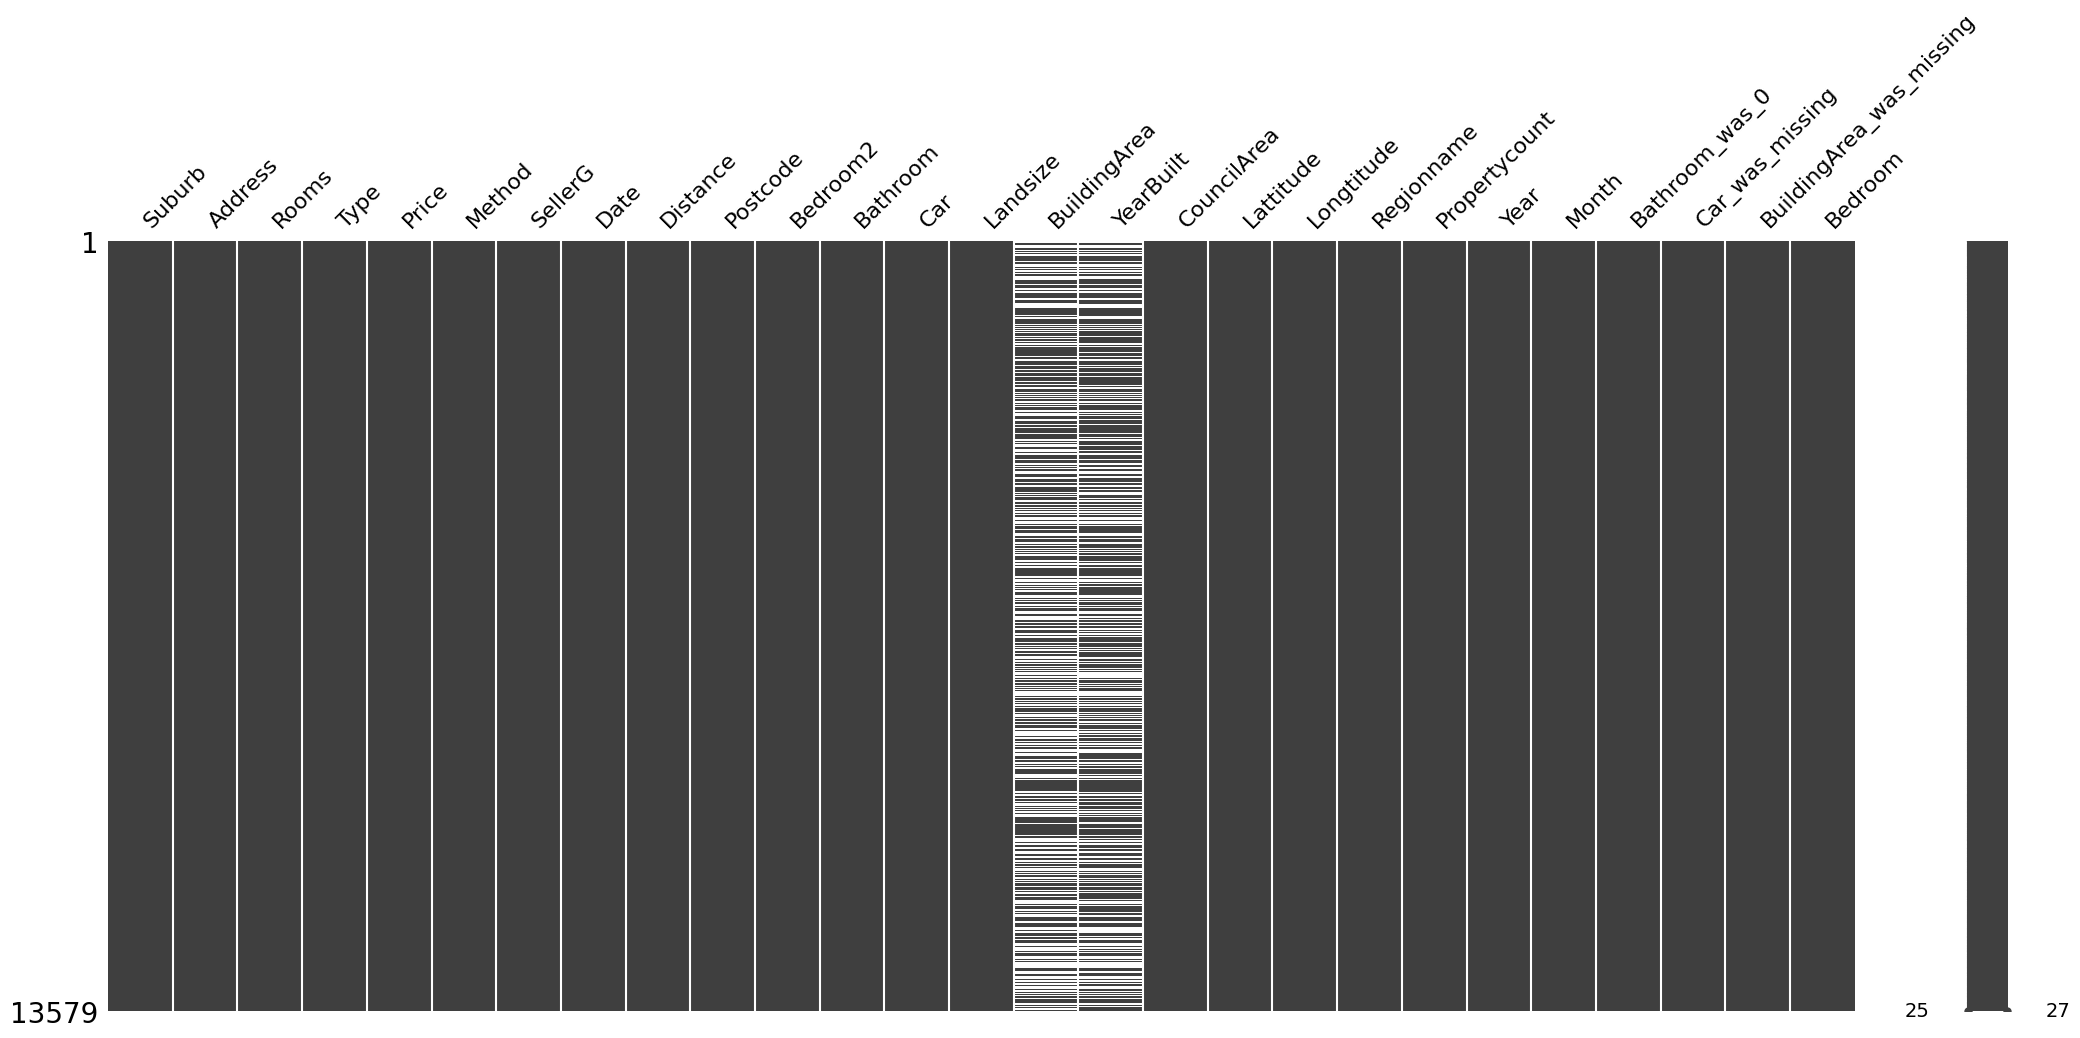

In [12]:
# Summarize the cleaned dataset to verify changes
print(melb_data.describe())

# Check for remaining missing values post-cleaning
print('\n Post-cleaning missing values across columns:')
print(melb_data.isna().sum())

# Visualize the cleaned data to ensure readiness for analysis
msno.matrix(melb_data)
plt.show()

### Handling Outliers

Identify and mitigate outliers in key quantitative columns such as 'Price', 'Bed', 'Bathroom', 'Car', 'Distance', 'Landsize', and 'BuildingArea'.


To ensure the quality of our data for modeling purposes, we focused on identifying and handling outliers within quantitative features: 'Price', 'Bed', 'Bathroom', 'Car', 'Distance', 'Landsize', and 'BuildingArea'. 

**Outlier Detection:**

We utilized boxplots to visualize the distribution of these features. Boxplots effectively reveal potential outliers, which are data points that fall significantly outside the main cluster of values.

**Outlier Verification and Treatment:**

1. **Verification:** We closely inspected the outliers for each feature. This involved examining the corresponding property information to verify the accuracy of the data points. Since many features had right-skewed distributions (more data points concentrated on the lower end), we paid particular attention to outliers on the left side of the boxplots.
2. **Treatment:** 
    * **Correction:** If an outlier was identified as an error in the data (e.g., incorrect entry during data collection), we corrected the value.
    * **Retention:** If an outlier was verified as a legitimate data point representing a genuine property characteristic (e.g., a particularly large property with a high price tag), we retained the value.

**Impact on Subsequent Steps:**

By addressing outliers, we ensure our model is trained on data that is more representative of the actual market. This can lead to more robust and generalizable model performance.

**Additional Considerations:**

During outlier analysis, we identified other data quality issues beyond outliers. We will address these issues in subsequent sections of this notebook as we progress through the data cleaning process.

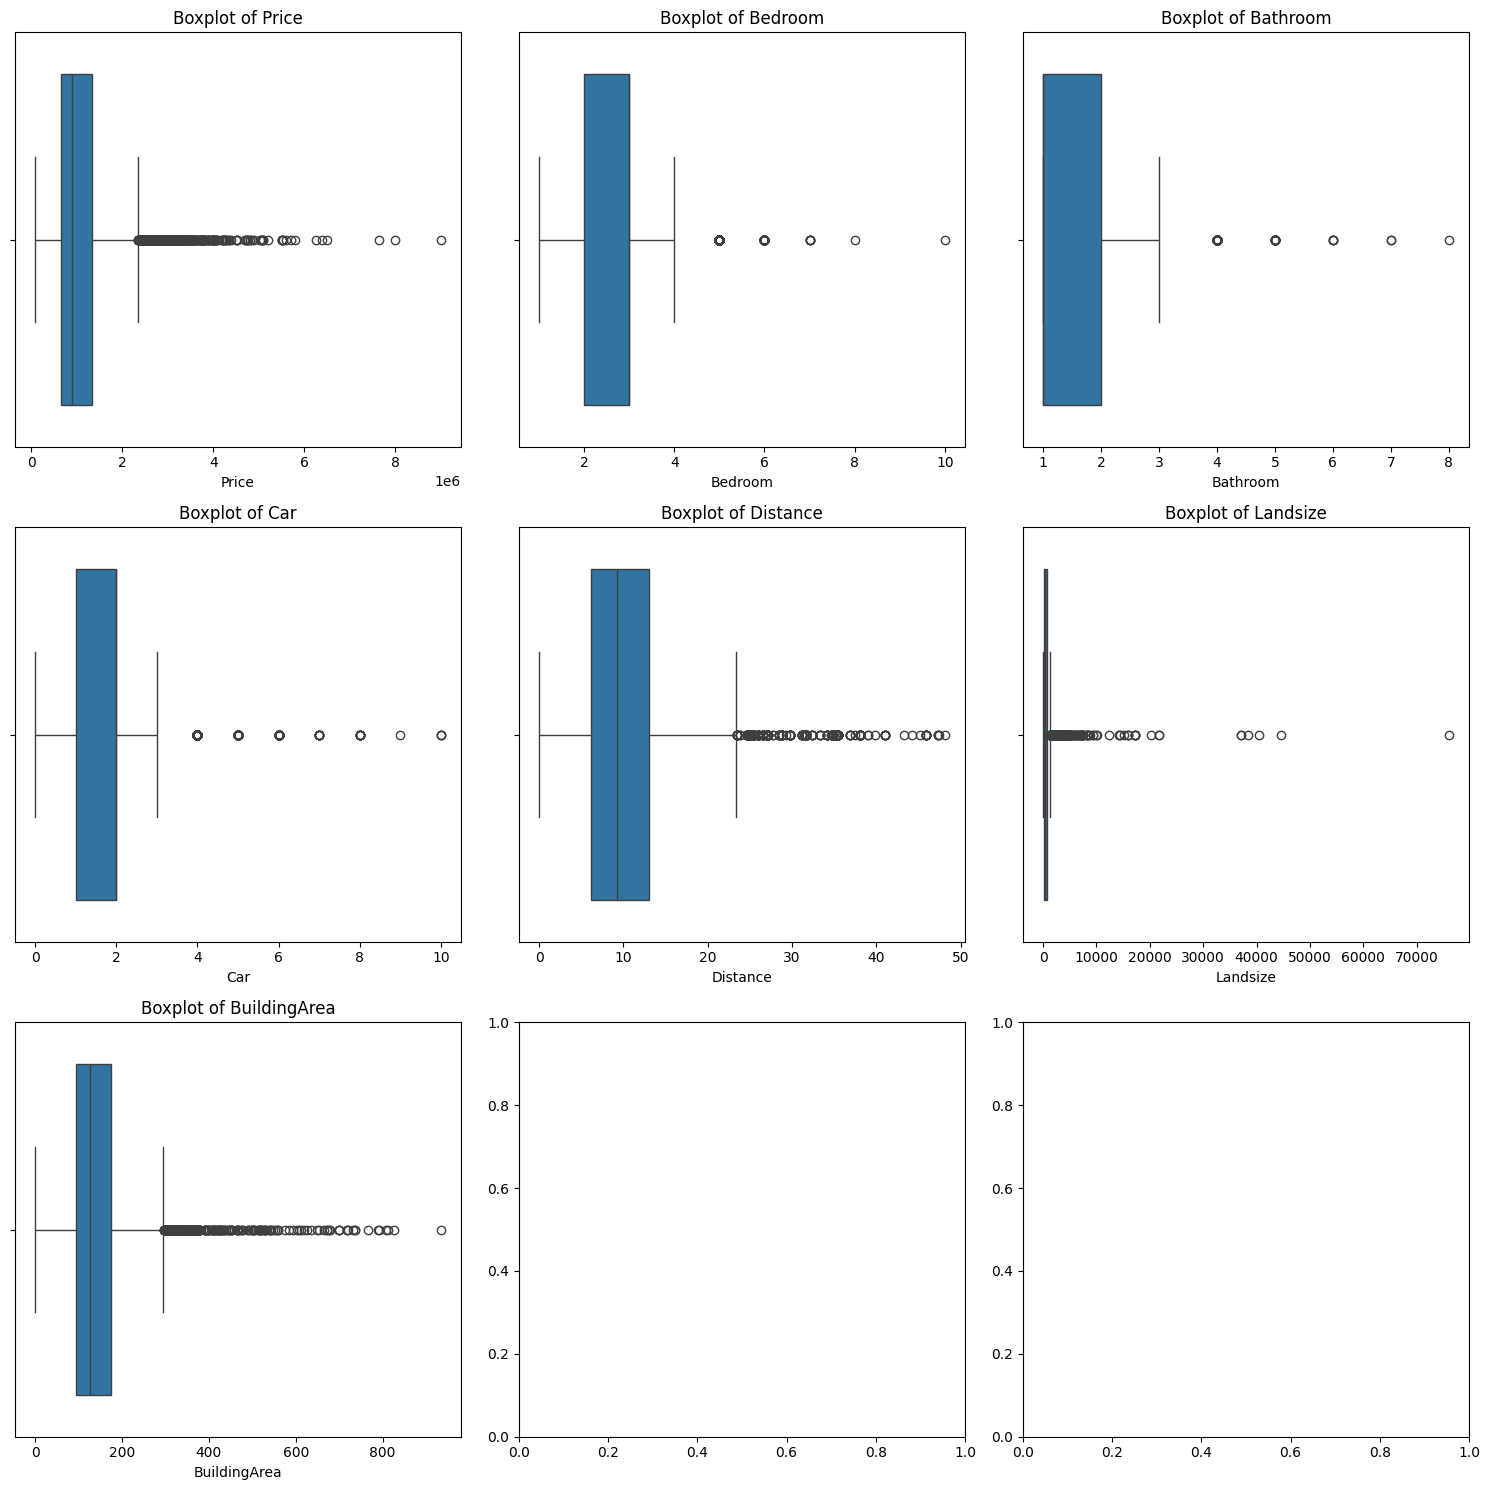

In [13]:
# Define quantitative columns
quant_columns = ['Price', 'Bedroom', 'Bathroom', 'Car', 'Distance', 'Landsize', 'BuildingArea']

# Plot boxplots to visualize outliers
plot_utils.plot_box(data=melb_data, column_list=quant_columns, rows=3, cols=3)

**Note**: Outliers were verified and do match the entries listed in the DataFrame.

#### Fixing Units with Zero Landsize

Units should not have a land size, so we will input zero for these entries as no one looks at the land size of a building for an apartment.

In [14]:
# Set 'Landsize' to 0 for units
melb_data.loc[melb_data['Type'] == 'u', 'Landsize'] = 0

# Create an indicator for imputed land sizes
melb_data['Landsize_Indicator'] = np.where(melb_data['Landsize'] == 0, 1, 0)

#### Handling Entries with Zero Building Area

A building area equal to zero does not make sense. We will impute these entries with our data.

In [15]:
# Impute 0 values in 'BuildingArea' with NaN
melb_data.loc[melb_data['BuildingArea'] == 0, 'BuildingArea'] = np.nan

#### Outlier Removal Using the IQR Method

While our outlier verification process confirmed the validity of some outlying data points, we encountered instances where outliers appeared excessively far from the rest of the data, even for legitimate properties. This situation was particularly observed in features like 'Price', 'Landsize', and 'BuildingArea'. These extreme values, despite being verified as real, could potentially hinder model performance due to their skewed influence.

**Impact on Modeling:**

Including these extreme outliers could lead to models that are overly sensitive to those values and perform poorly on more typical data points. 

**Solution: IQR-based Outlier Removal**

To address this concern and ensure our model learns from a more robust representation of the market, we employed the Interquartile Range (IQR) method for outlier removal. 

**IQR Method:**

The IQR method identifies outliers based on the distribution of data points within a specific feature. It calculates the interquartile range (IQR), which represents the middle 50% of the data, and then defines upper and lower bounds based on a threshold (typically 1.5 times the IQR) from the quartiles. Data points falling outside these bounds are considered outliers.

**Impact on Data Size:**

By implementing IQR-based outlier removal, we successfully eliminated these extreme outliers while maintaining a substantial dataset size. Our data size went from 13,579 entries to 12,622, representing a relatively small reduction.

**Benefits:**

This approach offers several benefits:

* **Improved Model Generalizability:** The model will be trained on a dataset that is more representative of the typical market, leading to better performance on unseen data.
* **Reduced Model Sensitivity:** The model will be less susceptible to the influence of extreme outliers, resulting in more robust predictions.

**Addressing Potential Concerns:**

While removing outliers can be valuable, it's important to acknowledge that there might be genuine edge cases within the removed data. However, in this instance, the reduction in data size was minimal, and the potential benefits for model generalizability outweigh the drawbacks.

In [16]:
# Loop through specified columns to handle outliers
for x in ['Price', 'Landsize']:
    # Calculate the first and third quartiles and interquartile range (IQR)
    q1, q3 = melb_data[x].quantile([0.25, 0.75])
    IQR = q3 - q1
    # Define upper and lower bounds for outliers
    upper, lower = q3 + (1.5 * IQR), q1 - (1.5 * IQR)
    # Remove outliers from the dataset
    melb_data = melb_data[melb_data[x].between(lower, upper)].copy()

In [17]:
# Handle outliers for the 'BuildingArea' column
# Calculate quartiles and IQR for 'BuildingArea'
q1, q3 = melb_data['BuildingArea'].quantile([0.25, 0.75])
IQR = q3 - q1
# Define outlier bounds for 'BuildingArea'
upper, lower = q3 + (1.5 * IQR), q1 - (1.5 * IQR)
# Filter out outliers, keeping NaN values
melb_data = melb_data[melb_data['BuildingArea'].isna() | melb_data['BuildingArea'].between(lower, upper)].copy()

### DataFrame Refinement

We performed several adjustments to further refine our DataFrame and prepare it for subsequent analysis:

* **Column Removal:** We removed columns that are no longer required, reducing the dimensionality of our dataset and focusing exclusively on features relevant to our analysis goals.
* **Column Reordering:** We reordered the columns within the DataFrame to prioritize key features and enhance readability for further analysis. 

**Purpose:**

These refinements streamline our dataset and facilitate effective visual and statistical analysis in the following stages of our project.

**Note:** If you'd like to include a list of the specific columns you removed or the rationale for the column reordering, feel free to add those details!


In [18]:
# Simplify the dataset by dropping columns not needed for further analysis
melb_data.drop(columns=['Rooms', 'Bedroom2', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount'], inplace=True)

# Reorder columns for readability and analysis purposes
melb_data = melb_data[[
    'Address', 'Postcode', 'Suburb', 'Regionname', 'CouncilArea', 'Type', 
    'Price', 'SellerG', 'Method', 'Date', 'Year', 'Month', 'Bedroom', 
    'Bathroom', 'Bathroom_was_0', 'Car', 'Car_was_missing', 'Distance',
    'Landsize', 'Landsize_Indicator', 'BuildingArea', 'BuildingArea_was_missing'
]]

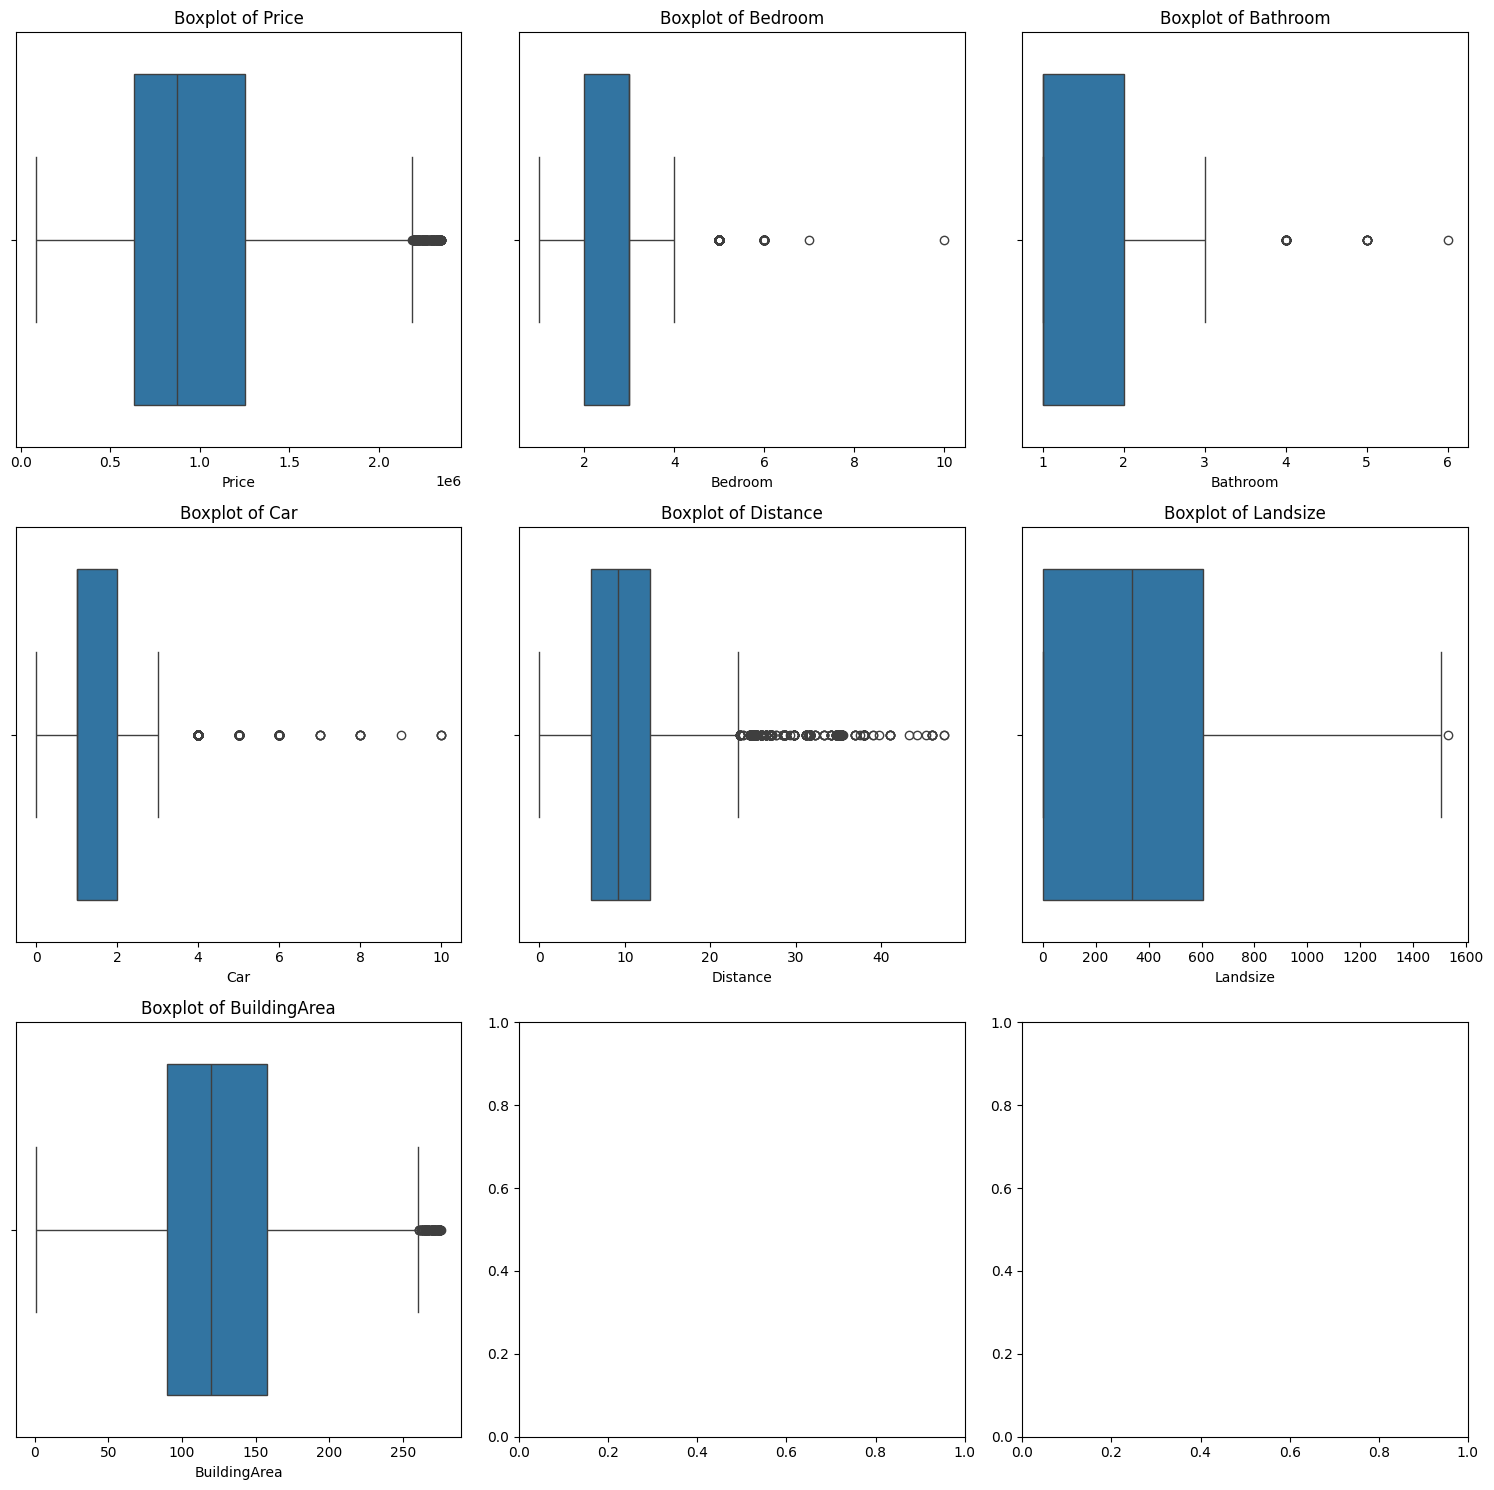

In [19]:
# Plot boxplots to visualize outliers
plot_utils.plot_box(data=melb_data, column_list=quant_columns, rows=3, cols=3)

In [20]:
# Review summary statistics post-outlier removal
print(melb_data.describe())

           Postcode         Price          Year         Month       Bedroom  \
count  12622.000000  1.262200e+04  12622.000000  12622.000000  12622.000000   
mean    3103.112819  9.718174e+05   2016.533513      7.036920      2.819759   
std       89.646530  4.480099e+05      0.498895      2.530705      0.892572   
min     3000.000000  8.500000e+04   2016.000000      1.000000      1.000000   
25%     3044.000000  6.320000e+05   2016.000000      5.000000      2.000000   
50%     3081.000000  8.720000e+05   2017.000000      7.000000      3.000000   
75%     3147.000000  1.253375e+06   2017.000000      9.000000      3.000000   
max     3977.000000  2.350000e+06   2017.000000     12.000000     10.000000   

           Bathroom           Car      Distance      Landsize  \
count  12622.000000  12622.000000  12622.000000  12622.000000   
mean       1.466012      1.566234     10.141705    357.796308   
std        0.606525      0.931967      5.828159    293.242358   
min        1.000000      0.0

## **'BuildingArea' Imputation**

### Preliminary Analysis

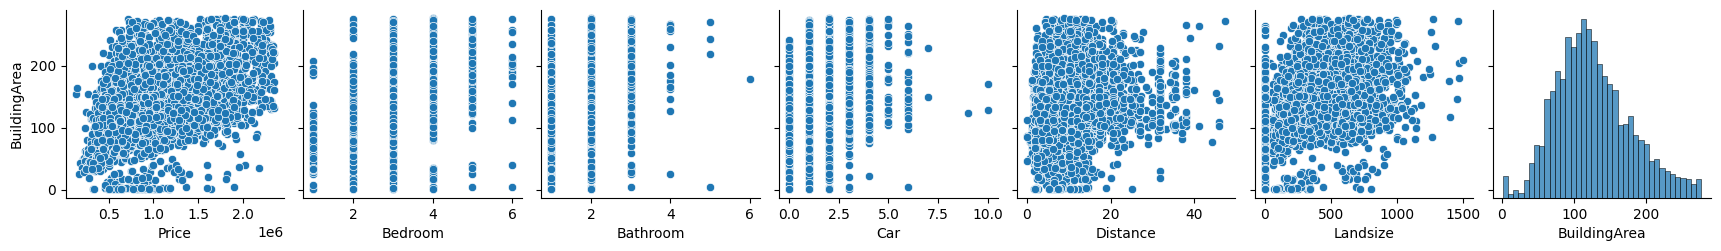

In [21]:
# Explore the relationships between quantitative variables and visualize correlations.
sns.pairplot(data=melb_data[quant_columns], y_vars='BuildingArea')
plt.show()

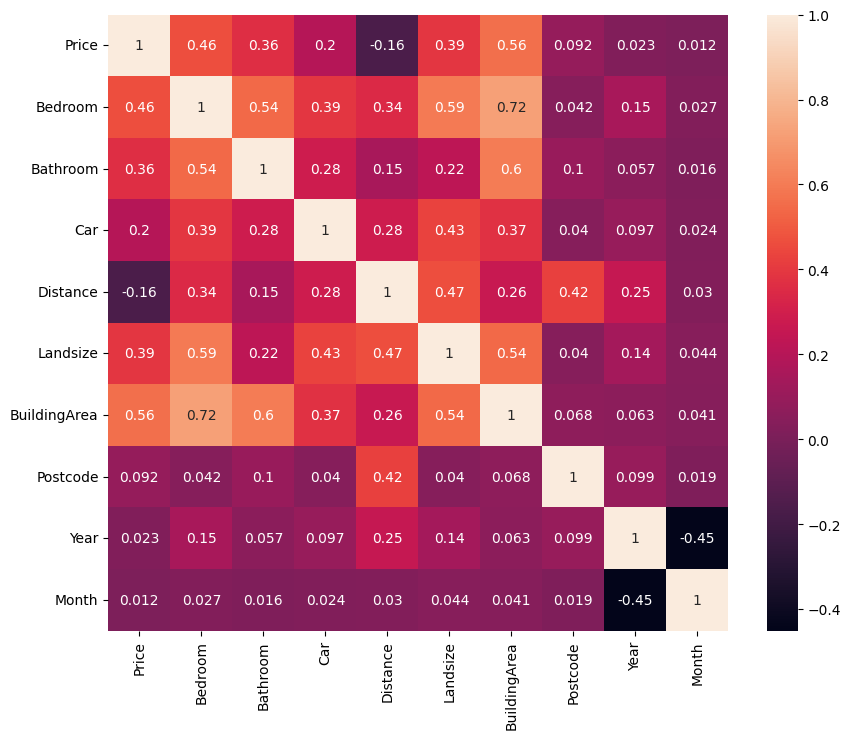

In [22]:
# Extend the list of quantitative columns with additional relevant features
quant_columns_ex = quant_columns + ['Postcode', 'Year', 'Month']

# Calculate the correlation matrix for the specified quantitative columns
corr_test = melb_data[quant_columns_ex].corr()

# Set the size of the figure
plt.figure(figsize=(10, 8))

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_test, annot=True)
plt.show()

### Feature Selection

#### Preparation for Feature Selection

#### Mutual Information (MI)

#### Recursive Feature Elimination (RFE)

**Initialize Your Estimator**:
Choose the model you want to use for feature selection and eventual prediction. Here, I'll use `RandomForestRegressor` as an example.

In [23]:
# Initialize a RandomForestRegressor as the estimator for RFE.
estimator = RandomForestRegressor(n_jobs=-1, random_state=42)


Now, apply `RFECV` to your data. You can specify the cross-validation strategy (e.g., K-fold) and the scoring metric you want to use.

*note*: we switched from `cv_strategy = StratifiedKFold(n_splits=5)` to `cv_strategy = KFold(n_splits=3, shuffle=True, random_state=42)` because `StratifiedKFold` is designed for classification tasks where the target variable is categorical (either binary or multiclass). For regression tasks, you should use `KFold` or another cross-validation generator that does not require the target to be categorical. 

**Review the Results**:
After fitting `RFECV` to your data, you can examine which features were selected and the optimal number of features.

Optimal number of features:  39
Best features:  Index(['Bedroom', 'Bathroom', 'Car', 'Distance', 'Landsize',
       'Northern Metropolitan_Regi', 'Southern Metropolitan_Regi',
       'Western Metropolitan_Regi', 'Darebin_Coun', 'Glen Eira_Coun',
       'Maribyrnong_Coun', 'Monash_Coun', 'Moonee Valley_Coun',
       'Moreland_Coun', 't_Type', 'u_Type', 'Barry_Sell', 'Brad_Sell',
       'Fletchers_Sell', 'Jellis_Sell', 'McGrath_Sell', 'Nelson_Sell',
       'RT_Sell', 'Ray_Sell', 'hockingstuart_Sell', 'S_Meth', 'SP_Meth',
       'VB_Meth', '2017_Year', '3_Mont', '4_Mont', '5_Mont', '6_Mont',
       '7_Mont', '8_Mont', '9_Mont', '10_Mont', '11_Mont', '12_Mont'],
      dtype='object')

In [24]:
top_features = ['Bedroom', 'Bathroom', 'Car', 'Distance', 'Landsize',
       'Northern Metropolitan_Regi', 'Southern Metropolitan_Regi',
       'Western Metropolitan_Regi', 'Darebin_Coun', 'Glen Eira_Coun',
       'Maribyrnong_Coun', 'Monash_Coun', 'Moonee Valley_Coun',
       'Moreland_Coun', 't_Type', 'u_Type', 'Barry_Sell', 'Brad_Sell',
       'Fletchers_Sell', 'Jellis_Sell', 'McGrath_Sell', 'Nelson_Sell',
       'RT_Sell', 'Ray_Sell', 'hockingstuart_Sell', 'S_Meth', 'SP_Meth',
       'VB_Meth', '2017_Year', '3_Mont', '4_Mont', '5_Mont', '6_Mont',
       '7_Mont', '8_Mont', '9_Mont', '10_Mont', '11_Mont', '12_Mont']

**Plot the CV Score vs. Number of Features**:
This helps visualize the performance of the model as you vary the number of features.

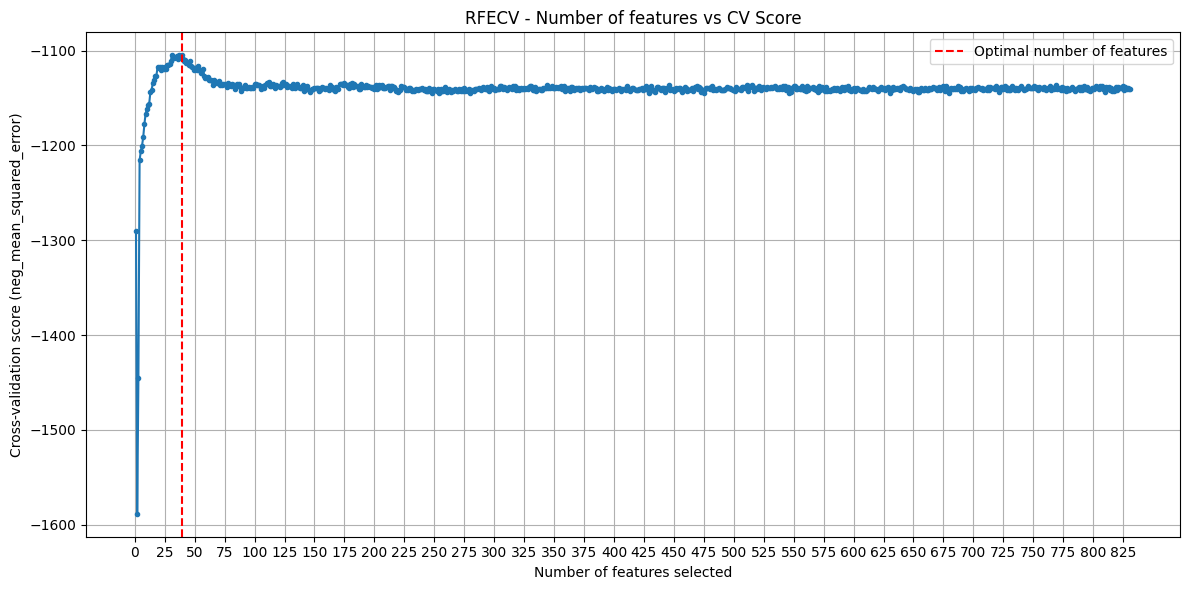

LOOK AT THE GRAPH AND THEN FITTING THE OPTIMAL FEATURES ON THE ACTUAL MODEL AND THEN LOOKING AT THE FEATURE IMPORTANT OF THE MODEL WILL TELL US WHICH TOP N FEATURE (IN OUR CASE LOOKING AT THE GRAPH IS 60) ARE THE MOST IMPORTANT FEATURE TO USE TO PREDICT OUR TARGET

NOTE: WE FIRST OBTAIN THE `predictive_features` FROM FEATURE SELECTION RFE THEN WE FIT THE `predictive_features` ON THE PREDICTIVE RANDOM FOREST MODEL TO SEE OUT OF ALL THE 'OPTIMAL' FEATURES THAT RFECV PICKED WHICH HAVE THE MOST FEATURE RELEVENCE IN COMBANATION OF THE Plot THAT SHOW the CV Score vs. Number of Features WHICH SHOW USE THE MINUMUM # OF FEATURES WE COULD USE FOR THE BEST 'neg_mean_squared_error' SCORE. SO IN TAKING THE MINMUM # OF FEATURE FROM THE PLOT WE TAKE THE TOP N FEATURE THAT IS RELAVENT TO THE MODEL AND THEN WILL REINPUT IT IN THE predictive_features WHICH WILL GIVE US THE OPTIMAL NUMBER OF FEATURES TO USE TO FIT ON TO OUR MODEL TO PREDICT FOR MISSING VALUES OF `BuildingArea`

### Preprocessing for Model Training with Optimized Feature from RFECV

In [25]:
# List of categorical features for dummy variable creation.
categorical_features = [
    'Postcode', 'Suburb', 'Regionname', 'CouncilArea', 'Type', 'SellerG',
    'Method', 'Year', 'Month'
]

# Creating dummy variables for categorical features and converting column names to strings.
melb_predict_data = func_utils.concat_dummies(melb_data, categorical_features)
melb_predict_data.columns = melb_predict_data.columns.astype(str)


# Define predictive features for model training.
predictive_features = top_features
target = 'BuildingArea'

# Drop rows with missing target variable and prepare the feature matrix (X) and target vector (y).
melb_ba_drop = melb_predict_data.dropna(subset=[target])
X = melb_ba_drop[predictive_features]
y = melb_ba_drop[target]

# Split the dataset into training and test sets with a 20% test size and set a random state for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

#### GridSearchCV for Random Forest

### Random Forest Model Fitting

In [26]:
'''
# Initialize the RandomForestRegressor with specified hyperparameters.
random_f_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'],
    random_state=42, n_jobs=-1
)
'''

random_f_model = RandomForestRegressor(
    n_estimators=450, max_depth=10, min_samples_split=18,
    random_state=42, n_jobs=-1)

# Fit the model to the training data.
random_f_model.fit(X_train, y_train)

# Predict on training and test data.
y_train_pred = random_f_model.predict(X_train)
y_test_pred = random_f_model.predict(X_test)

### Model Diagnostics

#### Cross Validation

In [27]:
# Perform 5-fold cross-validation to evaluate the model.
cv_scores = cross_val_score(random_f_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_scores = -cv_scores  # Convert scores to positive

# Print cross-validation scores, mean, and standard deviation.
print(f"CV MSE scores: {cv_scores}")
print(f"CV MSE mean: {cv_scores.mean()}")
print(f"CV MSE standard deviation: {cv_scores.std()}")

CV MSE scores: [1114.91263086 1040.69377919  988.34738188 1068.73559375 1083.67905142]
CV MSE mean: 1059.2736874190198
CV MSE standard deviation: 42.79391381404857


#### RMSE Calculation

In [28]:
# Calculate RMSE for both training and test datasets.
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Training RMSE: 26.90276513355946
Test RMSE: 32.42537138774422


### R² (R-squared)

In [29]:
# R² for training data
r2_train = r2_score(y_train, y_train_pred)

# R² for test data
r2_test = r2_score(y_test, y_test_pred)

print(f"R² for training data: {r2_train}")
print(f"R² for test data: {r2_test}")

R² for training data: 0.7363216448338548
R² for test data: 0.6245573496890935


#### MSE & MAE Calculation

In [30]:
# Calculate MSE and MAE for both training and test datasets.
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"\nTraining MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

Training MSE: 723.7587718314625
Test MSE: 1051.4047096331417

Training MAE: 18.60654068584101
Test MAE: 22.91793470467077


#### Feature Importance Analysis

In [31]:
# Assuming `X_train` includes both numerical and processed categorical variables.
feature_names = X_train.columns

# Extract feature importances from the model.
feature_importances = random_f_model.feature_importances_

# Create a Series for the feature importances for easy manipulation and sorting.
importances_series = pd.Series(
    feature_importances, index=feature_names
).sort_values(ascending=False)

print(importances_series)

Bedroom                       0.697123
Bathroom                      0.092734
Landsize                      0.071110
Distance                      0.028497
u_Type                        0.024104
Car                           0.008766
McGrath_Sell                  0.006494
Southern Metropolitan_Regi    0.004590
RT_Sell                       0.004230
11_Mont                       0.003162
Monash_Coun                   0.003089
Darebin_Coun                  0.003088
Jellis_Sell                   0.003059
t_Type                        0.003038
2017_Year                     0.003034
VB_Meth                       0.002954
Fletchers_Sell                0.002939
12_Mont                       0.002928
Ray_Sell                      0.002928
Brad_Sell                     0.002737
Northern Metropolitan_Regi    0.002294
6_Mont                        0.002016
4_Mont                        0.001985
9_Mont                        0.001909
5_Mont                        0.001873
Glen Eira_Coun           

### Imputing Missing 'BuildingArea' using Predictive Model

In [32]:
# Predict 'BuildingArea' for rows where it is missing and impute these values.
X_missing = melb_predict_data[melb_predict_data[target].isnull()][predictive_features]
predicted_values = random_f_model.predict(X_missing)
rounded_pv = np.round_(predicted_values, decimals=0)

# Impute the predicted 'BuildingArea' back into the original dataset.
melb_predict_data.loc[melb_predict_data[target].isnull(), target] = rounded_pv

# Extract original dataset columns after imputation to remove dummy variables used for prediction.
# This step restores the dataframe to its initial structure, focusing on key attributes relevant
# for further analysis or reference, following the imputation of 'BuildingArea' using a RandomForest model.
melb_data = melb_predict_data[['Address', 'Postcode', 'Suburb', 'Regionname', 'CouncilArea', 'Type', 
    'Price', 'SellerG', 'Method', 'Date', 'Year', 'Month', 'Bedroom', 
    'Bathroom', 'Bathroom_was_0', 'Car', 'Car_was_missing', 'Distance',
    'Landsize', 'Landsize_Indicator', 'BuildingArea', 'BuildingArea_was_missing']].copy()

## **Post-Analysis of 'BuildingArea' Imputation**

           Postcode         Price          Year         Month       Bedroom  \
count  12622.000000  1.262200e+04  12622.000000  12622.000000  12622.000000   
mean    3103.112819  9.718174e+05   2016.533513      7.036920      2.819759   
std       89.646530  4.480099e+05      0.498895      2.530705      0.892572   
min     3000.000000  8.500000e+04   2016.000000      1.000000      1.000000   
25%     3044.000000  6.320000e+05   2016.000000      5.000000      2.000000   
50%     3081.000000  8.720000e+05   2017.000000      7.000000      3.000000   
75%     3147.000000  1.253375e+06   2017.000000      9.000000      3.000000   
max     3977.000000  2.350000e+06   2017.000000     12.000000     10.000000   

           Bathroom           Car      Distance      Landsize  \
count  12622.000000  12622.000000  12622.000000  12622.000000   
mean       1.466012      1.566234     10.141705    357.796308   
std        0.606525      0.931967      5.828159    293.242358   
min        1.000000      0.0

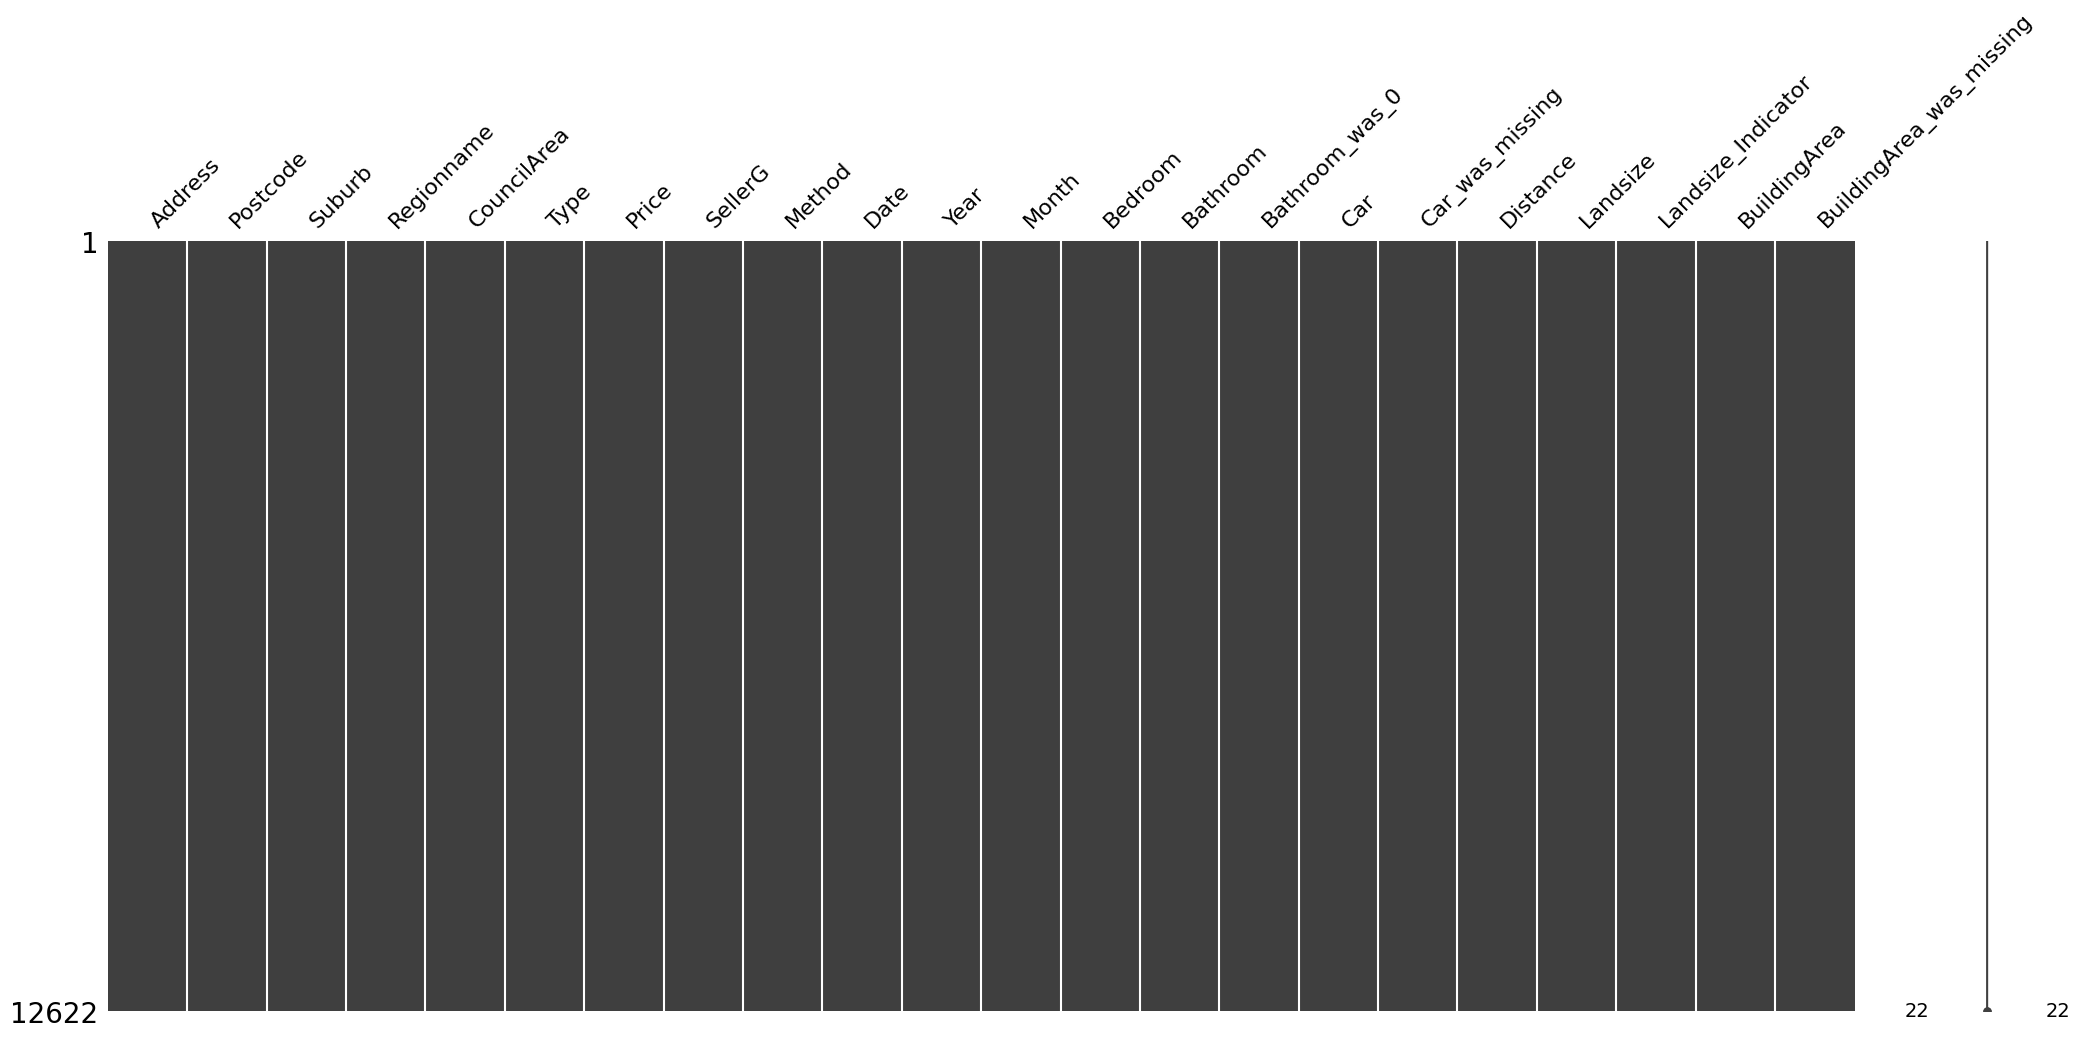

In [33]:
# Summarize the cleaned dataset to verify changes
print(melb_data.describe())

# Check for remaining missing values post-cleaning
print('\n Post-cleaning missing values across columns:')
print(melb_data.isna().sum())

# Visualize the cleaned data to ensure readiness for analysis
msno.matrix(melb_data)
plt.show()

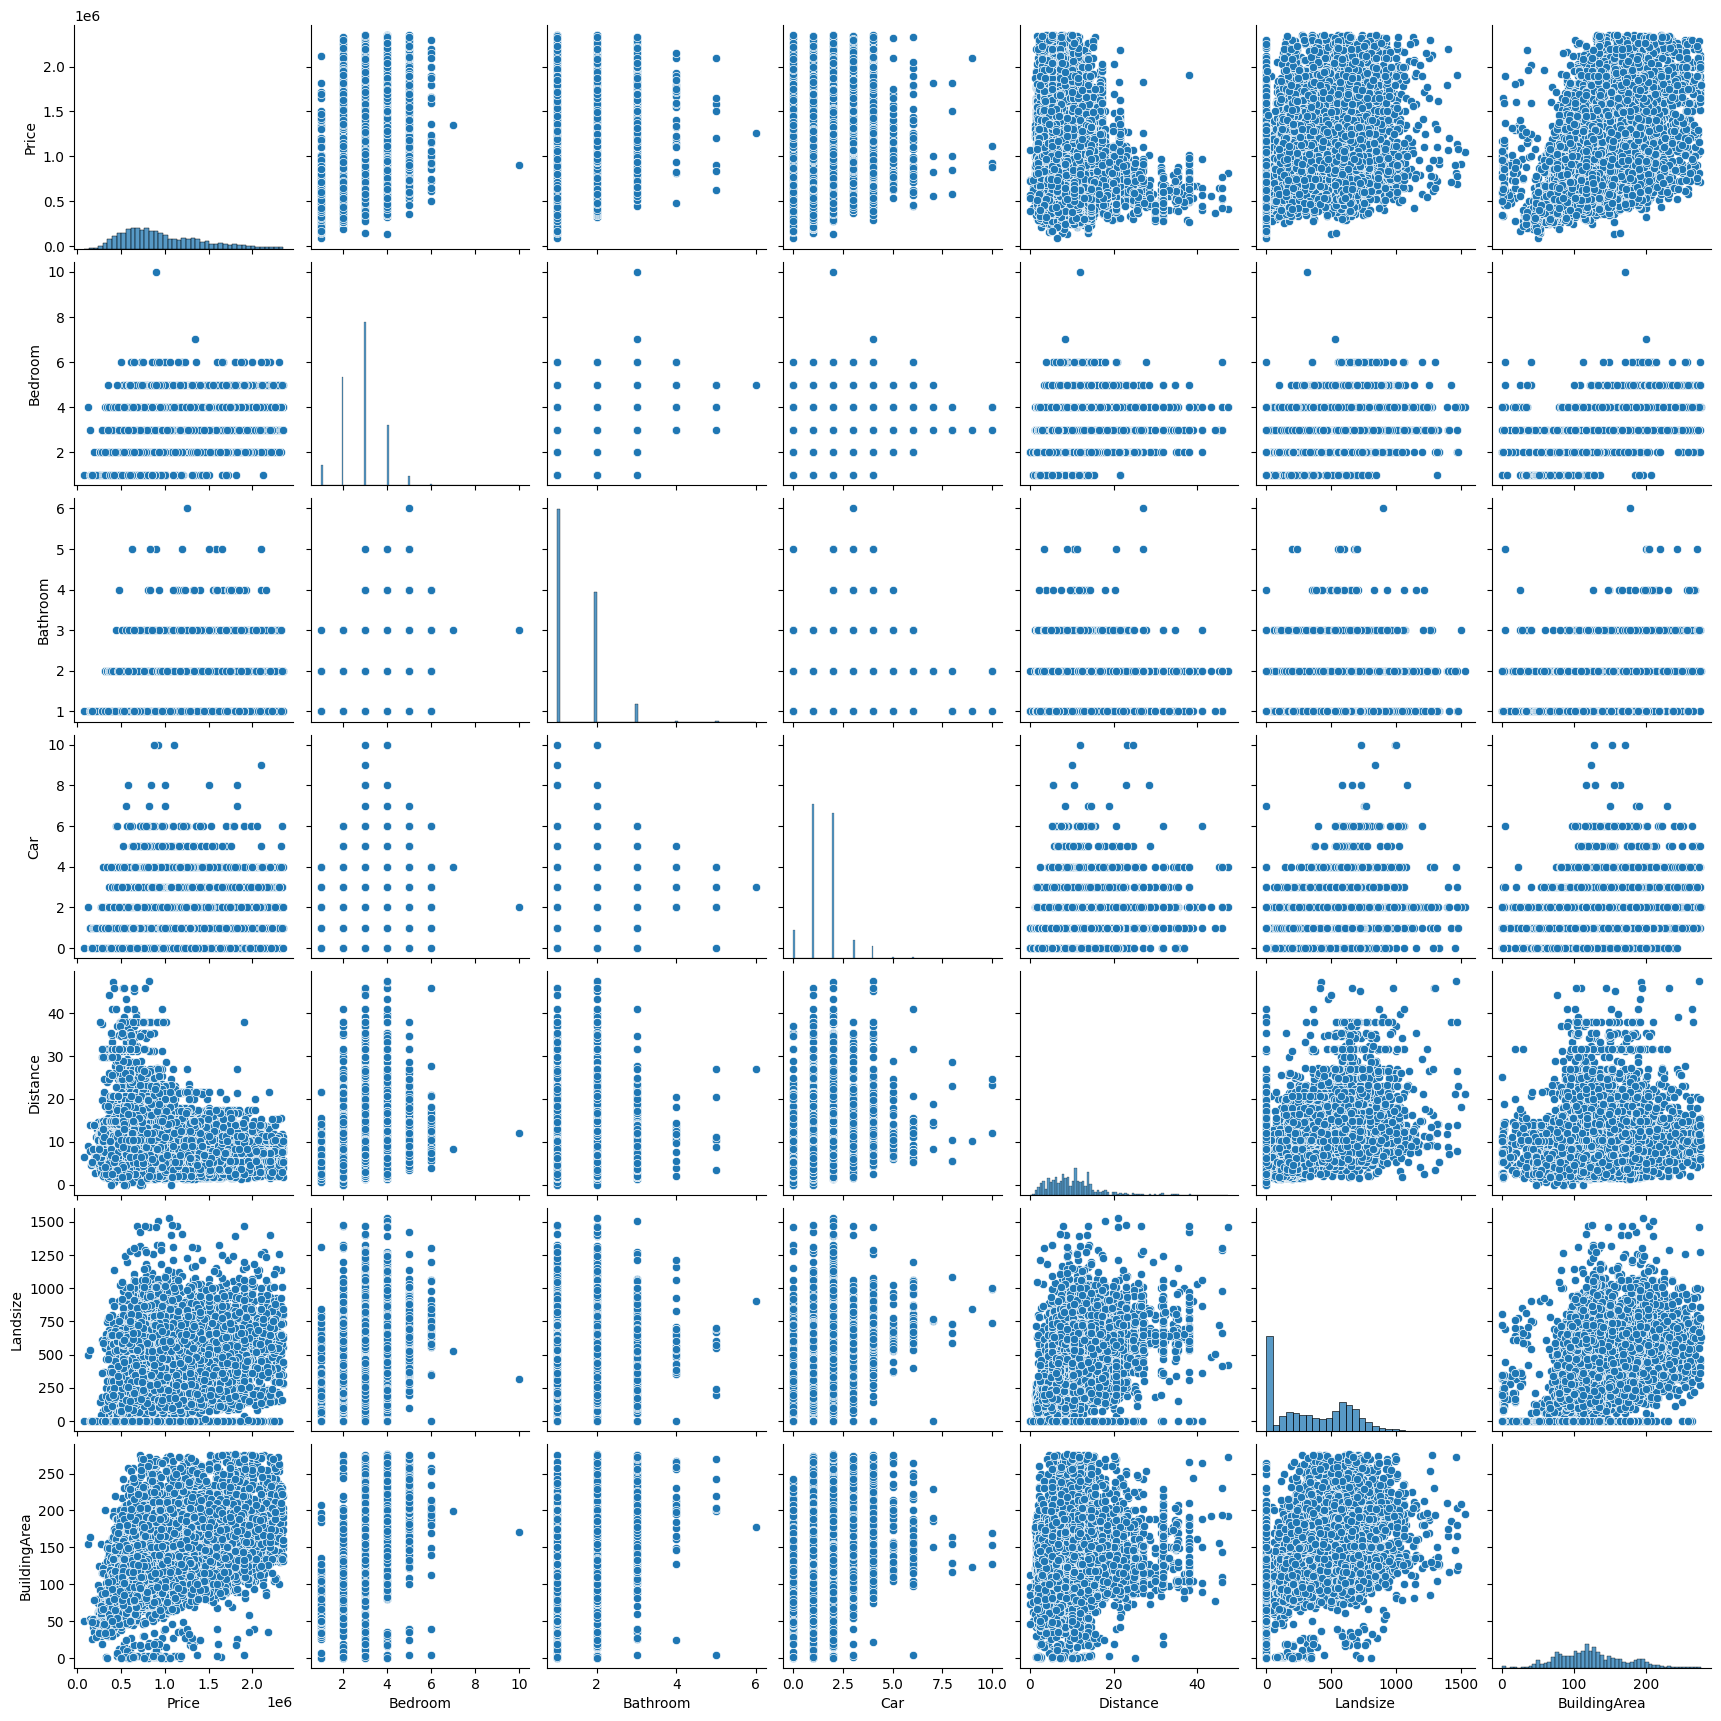

In [34]:
# Explore the relationships between quantitative variables and visualize correlations.
sns.pairplot(data=melb_data[quant_columns])
plt.show()

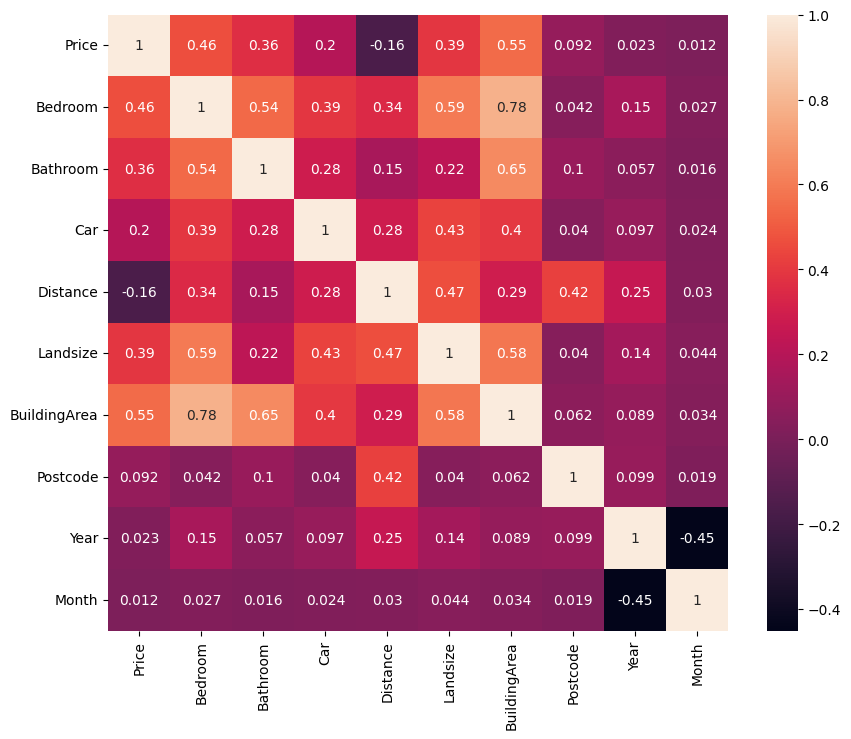

In [35]:
# Calculate the correlation matrix for the specified quantitative columns
corr_test = melb_data[quant_columns_ex].corr()

# Set the size of the figure
plt.figure(figsize=(10, 8))

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_test, annot=True)
plt.show()

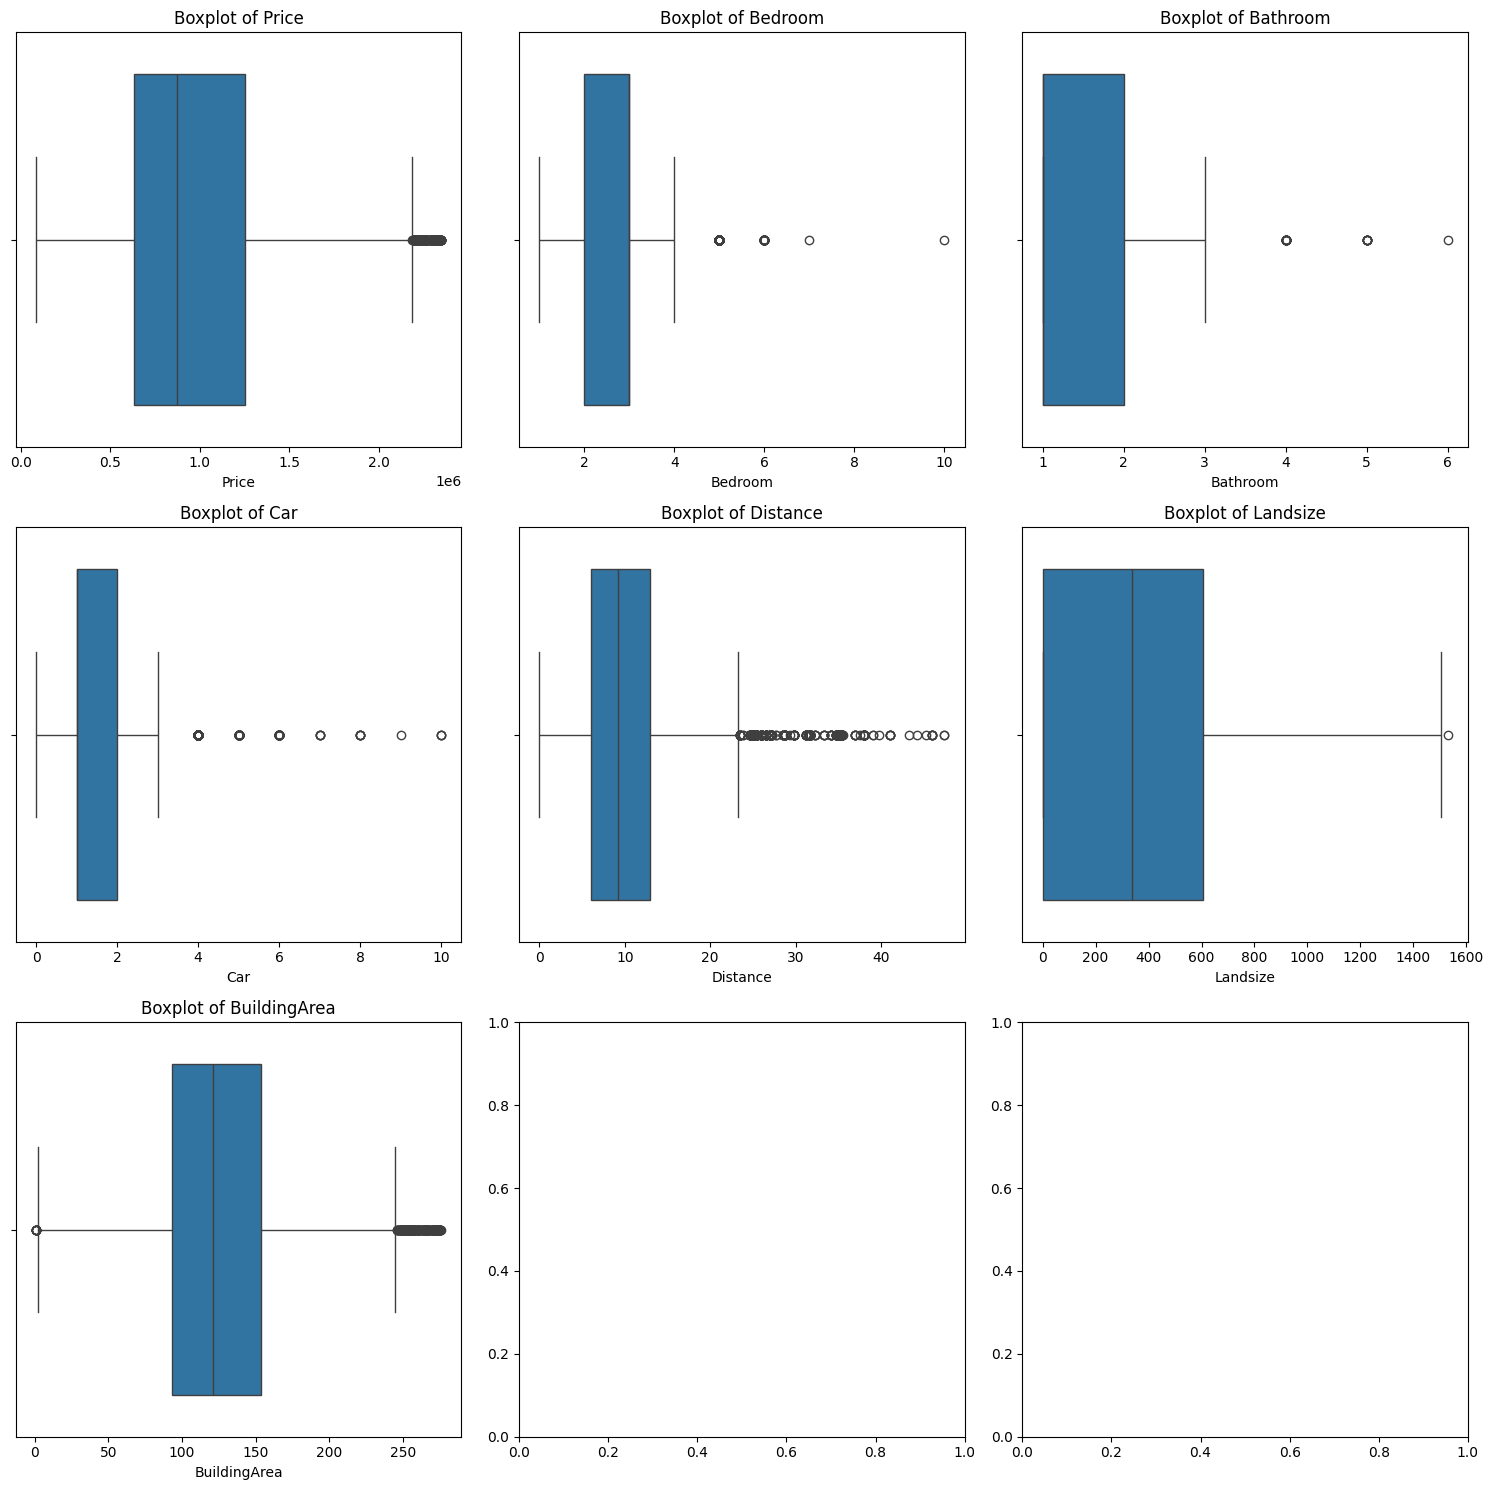

In [36]:
# Plot boxplots for selected quantitative variables to analyze distribution after 'BuildingArea' imputation.
plot_utils.plot_box(data=melb_data, column_list=quant_columns, rows=3, cols=3)

## **Export Data**

In [37]:
# Construct the full file path
output_file_path = os.path.join(script_dir, '01_Data_Cleaning', '1_cleaned_melb_data.csv')

# Export the cleaned and processed data to a new CSV file
melb_data.to_csv(output_file_path, index=False)  # Export without the index